# Case 2- EW Air Customer Segmentation

Student: Parth Agarwal

Student ID: 1001303127

Course: RSM2409

Professor: Dmitry Krass

## Data Setup

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

Read in csv file, skipping customer ID column because it is not useful for this analysis.

`df.info()` shows no missing data and consistent column type, so data can be used as-is.

In [27]:
df = pd.read_csv('EWAFF.csv',engine='python',usecols=range(1,20))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles?         3999 non-null   int64
 3   cc2_miles?         3999 non-null   int64
 4   cc3_miles?         3999 non-null   int64
 5   cc1_miles_bin      3999 non-null   int64
 6   cc2_miles_bin      3999 non-null   int64
 7   cc3_miles_bin      3999 non-null   int64
 8   Bonus_miles_12mo   3999 non-null   int64
 9   Bonus_trans_12mo   3999 non-null   int64
 10  Flight_miles_12mo  3999 non-null   int64
 11  Flight_trans_12    3999 non-null   int64
 12  Days_since_enroll  3999 non-null   int64
 13  Award?             3999 non-null   int64
 14  Online_12          3999 non-null   int64
 15  Email              3999 non-null   int64
 16  Club_member        3999 non-null   int64
 17  Any_cc_miles_1

Randomly partition data into `training` (50%) and `validation` (50%) samples. No test partition because this analysis is exploratory.

Note: `random_state` preserves a random state for consistency


In [28]:
train_df, valid_df = train_test_split(df, test_size=0.5, random_state=0)
print("Training   : ", train_df.shape)
print("Validation : ", valid_df.shape)

Training   :  (1999, 19)
Validation :  (2000, 19)


## Dimension reduction

### Manual Approach

Print correlation matrix for later usage in PCA.

Can scan for highly correlated columns with the following results:
- can drop `cc[1,2,3]_miles_bin`, because they are effectively covered by the `cc[1,2,3]_miles?` dummy variables based on correlation
- can drop `Any_cc_miles_12mo` because it has the same information as the `cc[1,2,3]_miles?` variables
- can drop `Flight_miles_12mo`, `Flight_trans_12` if new variable `avg_flight_miles` is created as ratio of first two variables

These reductions are not done because there are still too many diverse dimensions left afterwards. Some information resolution would also be lost.

In [29]:
corr_data = train_df.corr()
corr_data[(corr_data.abs()>.5)].round(4)

,Balance,Qual_miles,cc1_miles?,cc2_miles?,cc3_miles?,cc1_miles_bin,cc2_miles_bin,cc3_miles_bin,Bonus_miles_12mo,Bonus_trans_12mo,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,Online_12,Email,Club_member,Any_cc_miles_12mo,Phone_sale
Balance,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Qual_miles,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc1_miles?,NaN,NaN,1.0000,NaN,NaN,0.7014,NaN,NaN,0.5365,0.5560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9712,NaN
cc2_miles?,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc3_miles?,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,0.8106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc1_miles_bin,NaN,NaN,0.7014,NaN,NaN,1.0000,NaN,NaN,0.8344,0.5833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6812,NaN
cc2_miles_bin,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc3_miles_bin,NaN,NaN,NaN,NaN,0.8106,NaN,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bonus_miles_12mo,NaN,NaN,0.5365,NaN,NaN,0.8344,NaN,NaN,1.0000,0.5862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5276,NaN
Bonus_trans_12mo,NaN,NaN,0.5560,NaN,NaN,0.5833,NaN,NaN,0.5862,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5558,NaN


### Principal Component Analysis

`StandardScaler` standardizes with formula `z = (x - u) / s`

PCA (via the SVD algorithm) is run for up to 10 components using the correlation matrix. Summary results shown in table.

In [30]:
sc = StandardScaler()
df_scaled = sc.fit_transform(train_df)
pcs = PCA(n_components=10)
pcs.fit(corr_data)
pc_df = pd.DataFrame(pcs.transform(df_scaled))

pc_df.columns = ['PC' + str(i) for i in pc_df.columns]
pcaSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),\
                            'Proportion of variance': pcs.explained_variance_ratio_,\
                            'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)},index=pc_df.columns).transpose()
pcaSummary_df.round(4)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Standard deviation,0.6817,0.5155,0.4124,0.3232,0.2730,0.2359,0.2320,0.2141,0.1912,0.1626
Proportion of variance,0.3415,0.1953,0.1250,0.0767,0.0548,0.0409,0.0395,0.0337,0.0269,0.0194
Cumulative proportion,0.3415,0.5368,0.6618,0.7385,0.7933,0.8342,0.8737,0.9074,0.9343,0.9537


`Cumulative proportion` indicates that first three principal components account for 2/3rds of variance.

Scree plot shows a dip in proportion of variance after the first three principal components. With this in mind, `PC0`,`PC1`,`PC2` would be retained from the analysis.

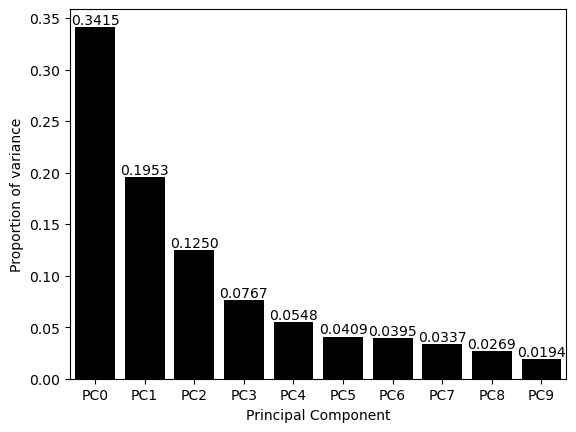

In [31]:
ax=sns.barplot(x=pc_df.columns, y=pcs.explained_variance_ratio_, color='k')
ax.bar_label(ax.containers[0],fmt='%.4f')
ax.set(xlabel='Principal Component',ylabel='Proportion of variance')
plt.show()

Loading table is created. The analysis will mainly focus on the first three principal components.

In [32]:
loadings = pd.DataFrame(pcs.components_.T, columns=pc_df.columns, index=train_df.columns)
loadings.round(4)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Balance,0.1543,0.2291,0.0463,0.1405,-0.2005,-0.1214,-0.0816,-0.0440,0.6929,-0.0840
Qual_miles,-0.0605,0.1309,-0.0103,0.1887,0.0437,-0.1188,0.6915,0.5398,0.0108,-0.0580
cc1_miles?,0.4695,-0.1445,-0.1083,-0.0626,-0.0310,0.0710,0.0830,0.0416,-0.0673,0.0976
cc2_miles?,-0.1234,-0.2113,-0.4235,-0.2776,-0.2463,-0.0492,-0.0151,-0.0540,0.0237,-0.0167
cc3_miles?,-0.0754,-0.2783,0.5384,-0.1478,-0.1865,-0.0608,0.0048,-0.0344,-0.0101,0.0367
cc1_miles_bin,0.4767,-0.0068,0.0523,0.0140,0.0008,-0.0346,0.0098,0.0661,0.0093,0.0307
cc2_miles_bin,-0.1272,-0.1566,-0.3895,-0.2829,-0.2275,-0.1328,-0.0625,-0.0798,0.0176,-0.0229
cc3_miles_bin,-0.0629,-0.2719,0.5436,-0.1604,-0.2190,-0.0627,0.0416,-0.0593,-0.0406,0.0345
Bonus_miles_12mo,0.3834,0.0529,0.1538,-0.0570,-0.0723,-0.0621,-0.0521,0.0401,0.0608,0.0141
Bonus_trans_12mo,0.3108,0.1869,0.0138,-0.2873,-0.0315,0.0693,-0.0624,0.0561,-0.0214,0.0780


With 3 PCs, there are 3 unique combinations of components to plot. None of the correlations are particularly strong, but some patterns may still be understood.

-----------
Observations:
- `cc1_miles?`,`Any_cc_miles_12mo`,`Bonus_miles_12mo` and `cc1_miles_bin` load on PC0
- `Flight_miles_12mo` and `Flight_trans_12` load well on PC1
- `cc3_miles` and `cc3_miles_bin` load on PC2 and slightly (negatively) on PC1 (could be noise)
- `cc2_miles` and `cc2_miles_bin` load (negatively) on PC2

The following groupings are made:
- `PC0` would be the credit card users who do not fly. They have accumulated a lot of points but do not spend them.
- `PC1` would be the frequent flyers, as they have accumulated a lot of miles through a lot of flights.
- `PC2` would be the small business owners given the accumulation of small business reward miles.

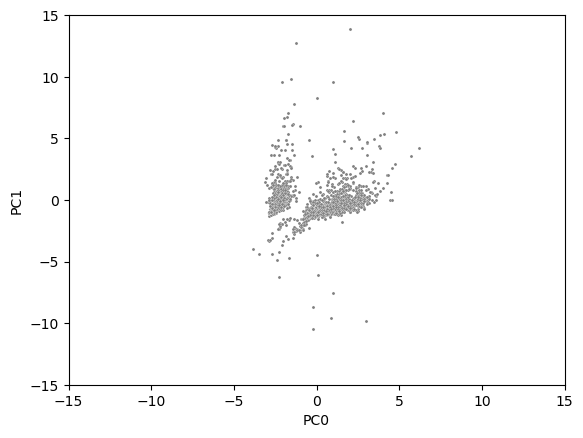

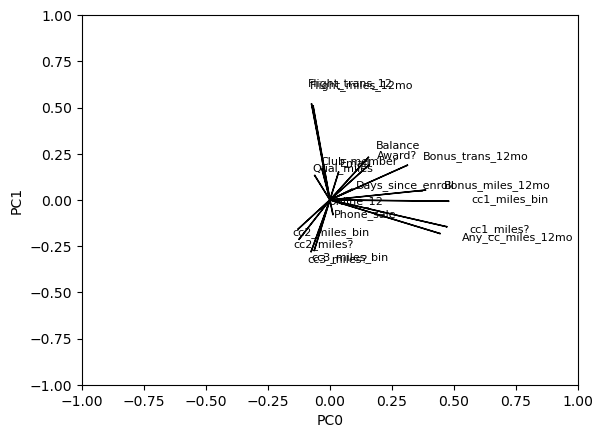

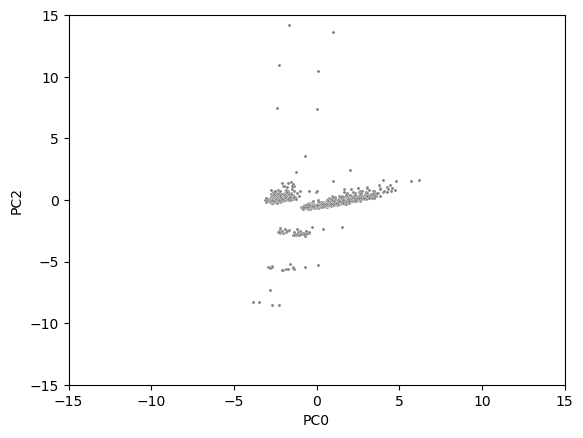

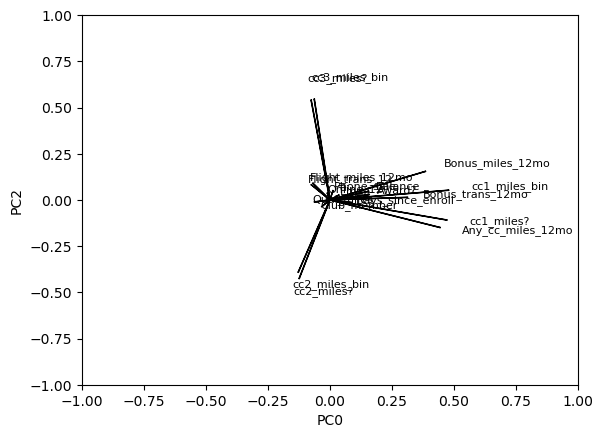

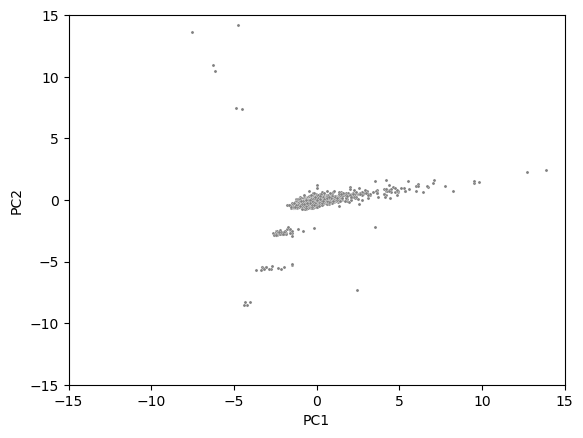

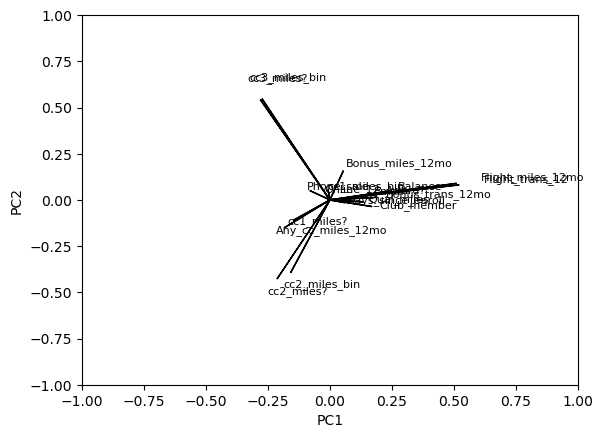

In [33]:
def scplot(model,xcom,ycom,seg=None):
    sns.scatterplot(x=model[xcom],y=model[ycom],s=5,hue=seg,palette='dark',color='grey')
    plt.xlim(-15,15)
    plt.ylim(-15,15)

def loadingplot(xcom,ycom):
    plt.xlabel(xcom)
    plt.ylabel(ycom)
    for i in range(len(loadings)):
        plt.arrow(0, 0, loadings[xcom][i], loadings[ycom][i],color='k')
        plt.text(loadings[xcom][i]*1.2, loadings[ycom][i]*1.2, list(loadings.index)[i], color='k', fontsize=8)
        plt.xlim(-1,1)
        plt.ylim(-1,1)


scplot(pc_df,'PC0','PC1');plt.show()
loadingplot('PC0','PC1');plt.show()
scplot(pc_df,'PC0','PC2');plt.show()
loadingplot('PC0','PC2');plt.show()
scplot(pc_df,'PC1','PC2');plt.show()
loadingplot('PC1','PC2');plt.show()

## Clustering Analysis

### K-Means clustering

`PC0`,`PC1`,`PC2` are composed of a reasonable set of variables and so they are being used for the k-means clustering.

Silhouette score is calculated below for 2-5 clusters. The greatest score is at 5 clusters, but there is not a significant difference between 2-5.

In [34]:
for n in range(2,7):
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(pc_df)
    centers = clusterer.cluster_centers_
    score = silhouette_score(pc_df, preds)
    print('With {} clusters, silhouette score is {:.4f})'.format(n, score))

With 2 clusters, silhouette score is 0.2751)
With 3 clusters, silhouette score is 0.2841)
With 4 clusters, silhouette score is 0.2906)
With 5 clusters, silhouette score is 0.3133)
With 6 clusters, silhouette score is 0.2291)


Elbow method diagram shows diminishing returns after 2 clusters, and moreso after 3. Contrary to silhouette scoring, it may be more reasonable to choose between 2 and 3.

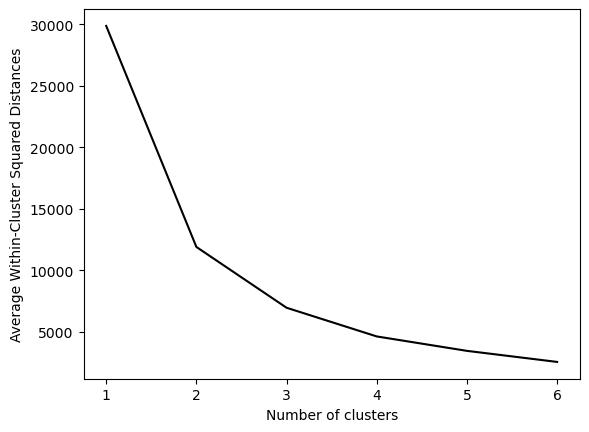

In [35]:
inertia = []
for n in range(1, 7):
 kmeans = KMeans(n_clusters=n,random_state=0).fit(pc_df)
 inertia.append(kmeans.inertia_ / n)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia',color='k')
plt.xlabel('Number of clusters')
plt.ylabel('Average Within-Cluster Squared Distances')
ax.legend().set_visible(False)
plt.show()

Based on visual inspection, the optimal number of clusters is 2.

Based on the silhoutte score and the elbow method, the optimal number of clusters appears to be either 2 or 3.

3 clusters are chosen for this analysis, and given more time other configurations would have been plotted.

-----------
Observations:
`PC0` - `PC1` plot shows a clear distinction between clusters. Top (green) group does not use the EWA points card `cc1` much but will fly frequently. Right (blue) group prefers to earn with points card more and fly less.
`PC0` - `PC2` plot shows that the green and blue groups are not users of the business cards. The left (orange) group shows the most inclination towards using the business card.
`PC1` - `PC2` plot also shows that the green group prefers to fly but do not use the business card.

The following labellings can made:
- Orange: Small business owners
- Green: Frequent flyers
- Blue: Personal credit card users

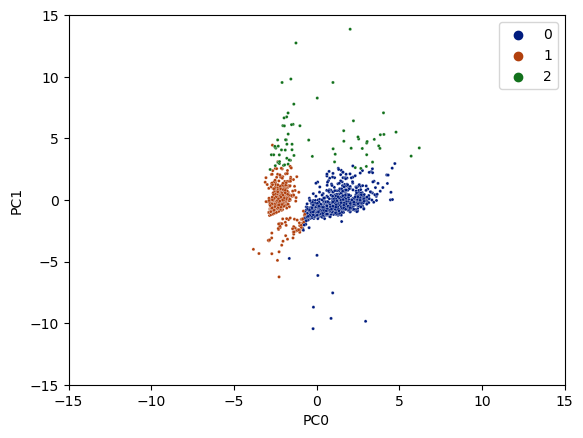

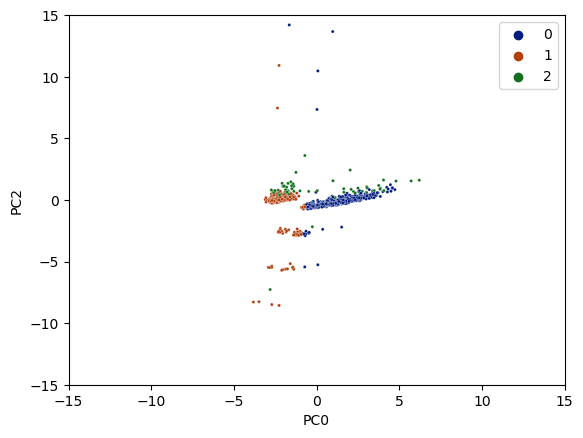

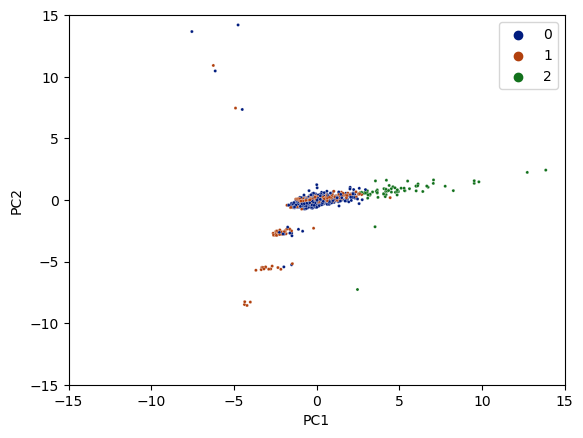

In [36]:
kmeans = KMeans(init='random',n_clusters=3,n_init=30,max_iter=300,random_state=0)
kmeans_seg=kmeans.fit_predict(pc_df)

scplot(pc_df,'PC0','PC1',kmeans_seg);plt.show()
scplot(pc_df,'PC0','PC2',kmeans_seg);plt.show()
scplot(pc_df,'PC1','PC2',kmeans_seg);plt.show()

## Validation

PCA validation is done with measuring the correlation between PCA of training and validation partitions. Initially tried transforming validation data using the original training model, but the transformed output yielded very low correlation. Then created new model from validation data, and loadings table now shows strong correlation.

In [37]:
pca_train = pc_df.iloc[:,:3]
loadings_train = loadings.iloc[:,:3]

# using the same model parameters from training data
# pca_valid = pd.DataFrame(pcs.transform(sc.transform(valid_df)),columns=pc_df.columns)
# pca_valid = pca_valid.iloc[:,:3]

# re-doing the PCA with validation data, creating new parameters
sc = StandardScaler()
pcs = PCA(n_components=3)
pcs.fit(valid_df.corr())
pca_valid = pd.DataFrame(pcs.transform(sc.fit_transform(valid_df)),columns=pca_train.columns)
loadings_valid = pd.DataFrame(pcs.components_.T, columns=['PC0V','PC1V','PC2V'], index=valid_df.columns)


loadings_train.apply(lambda s: loadings_valid.corrwith(s).round(4))

,PC0,PC1,PC2
PC0V,0.9912,-0.0898,-0.0470
PC1V,-0.0846,0.9926,-0.0414
PC2V,-0.0838,0.0015,0.9897


K-Means Cluster validation is done with comparing average centroid distances of clusters between training and validation partitions. Cluster groupings appear to be similar on observation, which is a good qualitative measure of validation.

(1999, 10)


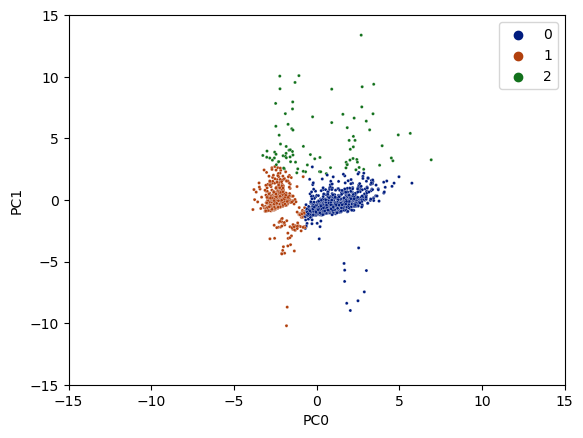

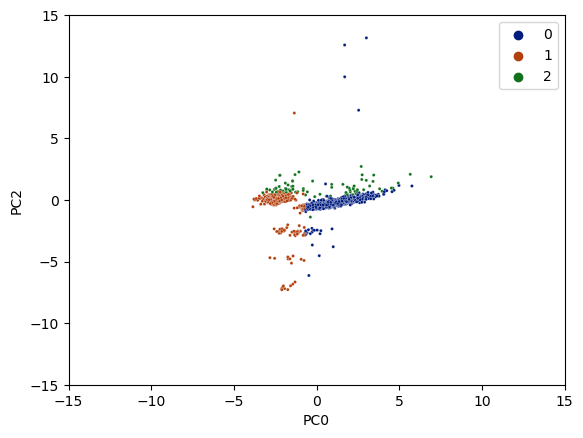

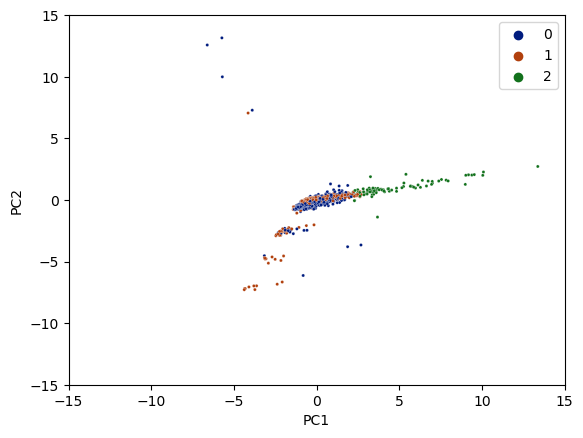

In [38]:
kmeans = KMeans(init='random',n_clusters=3,n_init=30,max_iter=300,random_state=2)
kmeans_seg_valid=kmeans.fit_predict(pca_valid)
print(pc_df.shape)
scplot(pca_valid,'PC0','PC1',kmeans_seg_valid);plt.show()
scplot(pca_valid,'PC0','PC2',kmeans_seg_valid);plt.show()
scplot(pca_valid,'PC1','PC2',kmeans_seg_valid);plt.show()

## Further Analysis

These plots will be used for supplementary analysis as the loading plots are not clear for several variables. Training and Validation data has been combined.

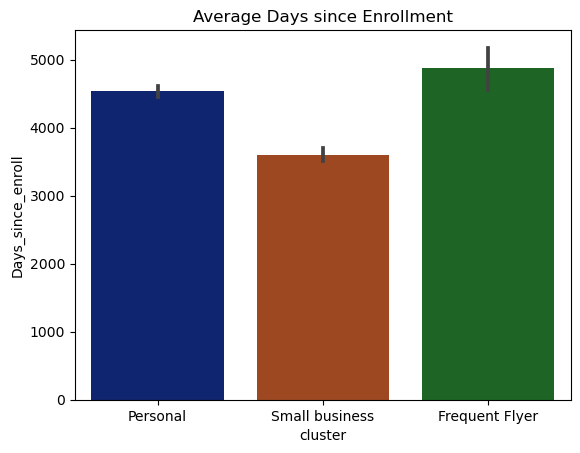

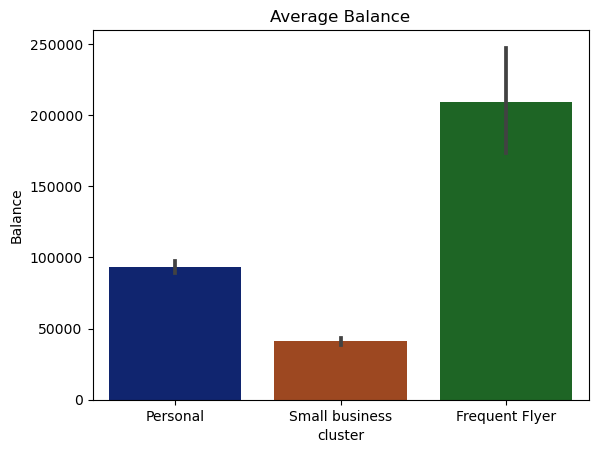

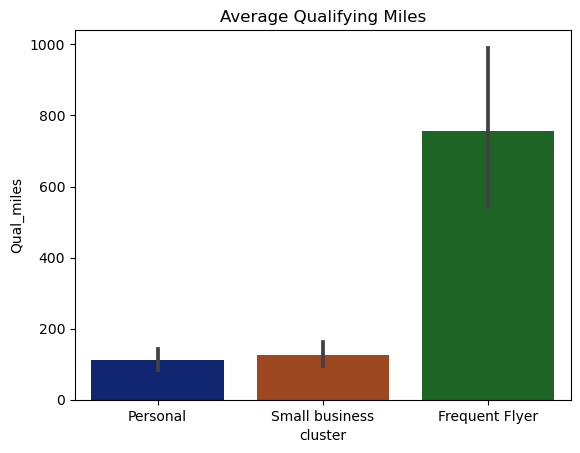

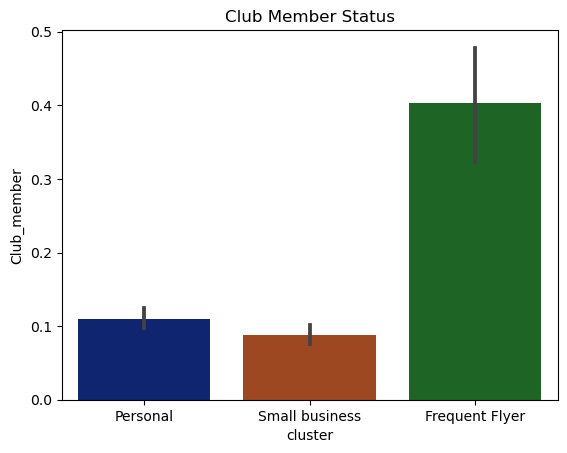

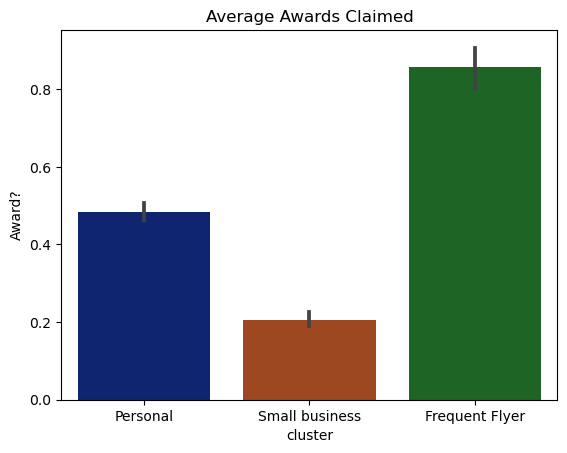

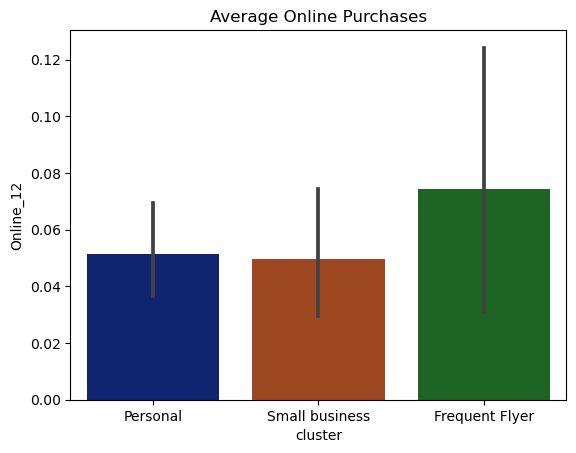

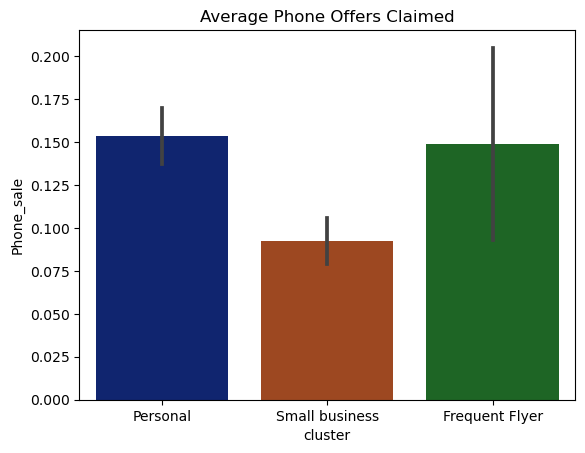

In [39]:
df_stats = pd.concat([train_df,valid_df])
df_stats['cluster'] = pd.concat([pd.Series(kmeans_seg,name='cluster'),pd.Series(kmeans_seg_valid,name='cluster')]).to_list()
df_stats['cluster'] = df_stats['cluster'].replace({0:'Personal',1:'Small business',2:'Frequent Flyer'})

sns.barplot(data=df_stats,y='Days_since_enroll',x='cluster',palette='dark');plt.title('Average Days since Enrollment');plt.show()
sns.barplot(data=df_stats,y='Balance',x='cluster',palette='dark');plt.title('Average Balance');plt.show()
sns.barplot(data=df_stats,y='Qual_miles',x='cluster',palette='dark');plt.title('Average Qualifying Miles');plt.show()
sns.barplot(data=df_stats,y='Club_member',x='cluster',palette='dark');plt.title('Club Member Status');plt.show()
sns.barplot(data=df_stats,y='Award?',x='cluster',palette='dark');plt.title('Average Awards Claimed');plt.show()
sns.barplot(data=df_stats,y='Online_12',x='cluster',palette='dark');plt.title('Average Online Purchases');plt.show()
sns.barplot(data=df_stats,y='Phone_sale',x='cluster',palette='dark');plt.title('Average Phone Offers Claimed');plt.show()

## Discussion

1) The following customers segments can be classified from PCA analysis:
- (PC0) personal credit card users
  - Loads for `cc1_miles?`,`Any_cc_miles_12mo`,`Bonus_miles_12mo` and `cc1_miles_bin`
- (PC1) frequent flyers
  - Loads for `Flight_miles_12mo` and `Flight_trans_12` (negatively for `cc3_miles` and `cc3_miles_bin`)
- (PC2) small business owners 
  - Loads for `cc3_miles` and `cc3_miles_bin` (negatively for `cc2_miles` and `cc2_miles_bin`)

  Although these segments can be spotted from PCA and cluster analysis, the correlation data is not that strong which limits the depth to which the customers segments can be identified.


2) `cc1` is a air miles card, `cc2` is a points card, and `cc3` is a business card.
- `cc1` has a clear customer segment of users based on high correlations with credit card usage and bonus miles collection. This is the preferred way to earn bonus miles.
- `cc2` does not have a clear segment of users, but it can be seen that small business owners will tend to not use the points card.
- `cc3` has a clear customer segment of users: PC2 loads noticeably on variables related to this credit card. It is also clear that frequent flyers tend not to use this.

  The air miles and business cards both have strong usage. The points card `cc2` is a weaker candidate to keep alive because of its unclear membership.


3) The loading plots show that bonus miles are being accumulated through both flight miles (PC1) and credit card miles (PC0). There is no discernable difference between short distance and long distance flyers.


4) The loading plots do not show any significant patterns regarding `Club_member` and `Qual_miles`. However, the **Club Member Status** plot shows that the average frequent flyer is more likely to be a club member. Per the **Average Qualifying Miles** plot, frequent flyers have significantly more qualifying miles on average. Club members and those accumulating qualifying miles both belong to the frequently flyer group.

   
5) The current structure appeals mainly to frequent flyers, because when the customers are segmented by flying habits, the frequent flyers are identified as being the closest to Topflight Status by far. It should be noted that there are little to no customers who have enough qualifying miles to qualify for Topflight Status, much less than the desired 10-15%. This means that the majority of active customers fall into the 'everyone else' category - this means that either the status is difficult to achieve or the benefits are not competive enough, and the latter is a listed pain point for the firm. Furthermore, there is no reason for small business owners or personal miles collectors to reach Topflight Status because they engage with EWA products for bonus rewards and not for flights - parallel tiers in the structure could serve to incentivize these segments. 